# Python и статистика

Проект № 3 - статистический вывод, поиск причин аномалий в данных.

# Введение
## Постановка задачи

Представьте, что вы работаете аналитиком в компании, которая занимается арендой велосипедов. Коллега из офиса в Лондоне прислал вам данные за два года: с 4 января 2015 по 3 января 2017. Вам предстоит изучить динамику числа аренд, наличие связи с погодными условиями и выходными, а также объяснить несколько аномалий на графике.

## Описание данных

- ```timestamp``` – дата и время (точность до часа)
- ```cnt``` – количество аренд велосипедов за этот час
- ```t1``` – температура, в С
- ```t2``` – температура "ощущается как", в С 
- ```hum``` – влажность (%)
- ```wind_speed``` – скорость ветра, км/ч
- ```weather_code``` – погодные условия:
    - 1 – ясно (SKC)
    - 2 – преимущественно ясно / встречаются отдельные облака (SCT)
    - 3 – облачно / значительные облака (BKN)
    - 4 – пасмурно (OVC)
    - 7 – небольшой дождь Rain/ light Rain shower/ Light rain 
    - 10 – дождь с грозой
    - 26 – снегопад 
    - 94 – ледяной туман (да, такое бывает!)
- ```isholiday``` – является ли день праздником (1 – праздник, 0 – нет)
- ```isweekend``` –  является ли день выходным (1 – выходной, 0 – нет)
- ```season``` – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)

# Предварительная работа с данными

## Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np, scipy.stats as st

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных

In [2]:
df = pd.read_csv('./data/london.csv', parse_dates = ['timestamp'])

In [3]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


## Предобработка данных

### Проверка на дубликаты и отсутствующие значения:

In [4]:
def cols_word(n_cols: int) :
    if (n_cols % 100 > 10) and (n_cols % 100 < 20) :
        return ('колонок')
    elif (n_cols % 10 == 1) :
        return('колонка')
    elif (n_cols % 10 in [2, 3, 4]) :
        return('колонки')
    else :
        return('колонок')

def rows_word(n_rows: int) :
    if (n_rows % 100 > 10) and (n_rows % 100 < 20) :
        return ('колонок')
    elif (n_rows % 10 == 1) :
        return('строка')
    elif (n_rows % 10 in [2, 3, 4]) :
        return('строки')
    else :
        return('строк')
    
a0 = df.shape[0]
a1 = df.shape[1]
a2 = df.dropna().shape[0]
a3 = df.drop_duplicates().shape[0]

print(a0, rows_word(a0), "и", a1, cols_word(a1))
print(a2, rows_word(a2), "после удаления строк, содержащих NULL")
print(a3, rows_word(a3), "после удаления дубликатов")

17414 колонок и 10 колонок
17414 колонок после удаления строк, содержащих NULL
17414 колонок после удаления дубликатов


### Проверка типов данных

In [5]:
df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

Т.к. колонка ```timestamp``` изначально загружается как объект, мы сразу же, в разделе **Загрузка библиотек и данных**, при импорте файла добавили опцию обработки этой колонки как содержащей дату/время.

Преобразуем типы данных в нескольких колонках из формата *float*, т.к. это категориальные/номинативные переменные, принимающие целочисленные значения:

In [6]:
df[['weather_code', 'is_holiday', 'is_weekend', 'season']] = \
    df[['weather_code', 'is_holiday', 'is_weekend', 'season']].astype('int64')

In [7]:
df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code             int64
is_holiday               int64
is_weekend               int64
season                   int64
dtype: object

# Решение поставленных задач

Посмотрим на число поездок по датам и времени

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

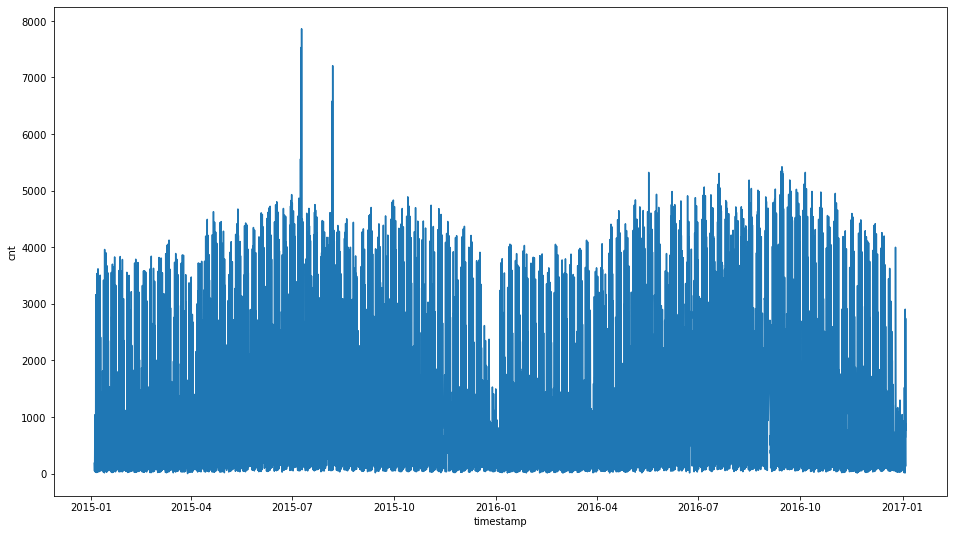

In [8]:
plt.figure(figsize=(16,9))
sns.lineplot(data = df,
             x = 'timestamp',
             y = 'cnt')

Усредним данные для того, чтобы лучше видеть имеющиеся закономерности

In [9]:
df_daily = df.set_index('timestamp').resample(rule = 'D')['cnt'].sum().to_frame()

In [10]:
df_daily.head()

,cnt
timestamp,
2015-01-04,9234
2015-01-05,20372
2015-01-06,20613
2015-01-07,21064
2015-01-08,15601


<AxesSubplot:xlabel='timestamp'>

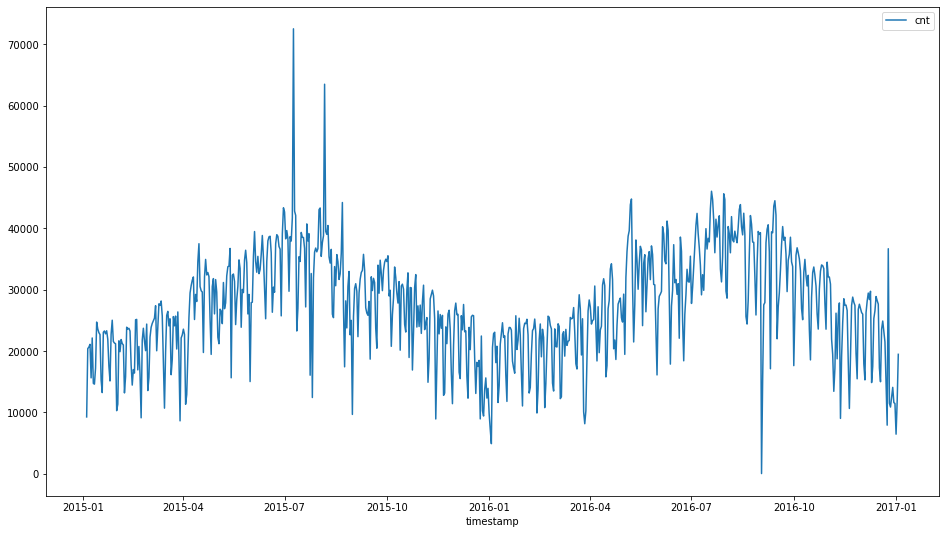

In [11]:
plt.figure(figsize=(16,9))
sns.lineplot(data = df_daily)

Возьмём агрегированные данные по дням с предыдущего шага и посчитайте скользящее среднее с окном 3

In [12]:
df_daily['cnt_rolling_3'] = df_daily.rolling(3).mean()

<AxesSubplot:xlabel='timestamp', ylabel='cnt_rolling_3'>

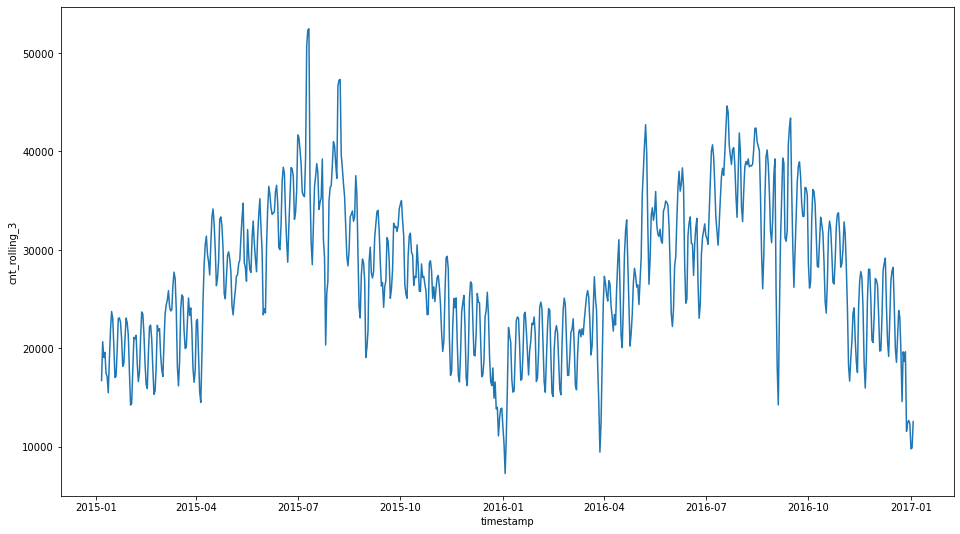

In [13]:
plt.figure(figsize=(16,9))
sns.lineplot(data = df_daily['cnt_rolling_3'].dropna())

In [14]:
np.around(df_daily['cnt_rolling_3'].loc['2015-07-09'].item()).astype(int)

50705

In [15]:
np.around(df_daily.loc['2015-07-09']['cnt_rolling_3']).astype(int)

50705

Подсчитаем разницу между наблюдаемыми и подсчитанными значениями:

In [16]:
df_daily['cnt_diff'] = df_daily['cnt'] - df_daily['cnt_rolling_3']

Применим функцию для подсчета стандартного отклонения

In [17]:
std = np.std(df_daily['cnt_diff'])
np.around(std, 2)

4558.59

Теперь определим границы интервалов. Для этого нужно взять данные, полученные при расчете скользящего среднего, и создать следующие объекты:

- upper_bound – верхняя граница; к средним прибавляем $2.576 \cdot \mbox{std}$
- lower_bound – нижняя граница; вычитаем $2.576 \cdot \mbox{std}$

Полученные значения запишем в новые столбцы датафрейма с агрегированными данными.

*Note: в качестве std нужно брать стандартное отклонение без округления.*

*Note 2: может понадобиться убрать даты из индекса -- иногда из-за этого колонки могут не присваиваться в датафрейм -- для чего пригодится ```.reset_index()```.*

In [18]:
df_daily = df_daily.reset_index()

In [19]:
df_daily['upper_bound'] = df_daily['cnt_rolling_3'] + 2.576 * std
df_daily['lower_bound'] = df_daily['cnt_rolling_3'] - 2.576 * std

In [20]:
round(df_daily.tail(1)['upper_bound'].item(), 2)

24302.92

Изучим аномально высокие значения. Выведем наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.

In [21]:
df_daily.query("cnt > upper_bound")

,timestamp,cnt,cnt_rolling_3,cnt_diff,upper_bound,lower_bound
186,2015-07-09,72504,50705.000000,21799.000000,62447.919188,38962.080812
214,2015-08-06,63468,46627.333333,16840.666667,58370.252521,34884.414146
609,2016-09-04,27512,14259.000000,13253.000000,26001.919188,2516.080812
721,2016-12-25,36653,19650.666667,17002.333333,31393.585854,7907.747479


**2015-07-09**

https://www.bbc.com/russian/international/2015/07/150709_london_tube_strike

*Крупнейшая за последнее десятилетие 24-часовая стачка работников метро, начавшаяся в среду вечером, привела к транспортному коллапсу в британской столице. Автобусные остановки переполнены людьми, многие вынуждены добираться до пунктов назначения пешком.*

*Другие виды транспорта работают в обычном или даже усиленном режиме, но нагрузка на них заметно возросла.*

Проделаем аналогичную операцию для дней, когда число аренд оказалось ниже ожидаемого

In [22]:
df_daily.query("cnt < upper_bound")

,timestamp,cnt,cnt_rolling_3,cnt_diff,upper_bound,lower_bound
2,2015-01-06,20613,16739.666667,3873.333333,28482.585854,4996.747479
3,2015-01-07,21064,20683.000000,381.000000,32425.919188,8940.080812
4,2015-01-08,15601,19092.666667,-3491.666667,30835.585854,7349.747479
5,2015-01-09,22104,19589.666667,2514.333333,31332.585854,7846.747479
6,2015-01-10,14709,17471.333333,-2762.333333,29214.252521,5728.414146
...,...,...,...,...,...,...
726,2016-12-30,11566,12682.000000,-1116.000000,24424.919188,939.080812
727,2016-12-31,11424,12347.333333,-923.333333,24090.252521,604.414146
728,2017-01-01,6421,9803.666667,-3382.666667,21546.585854,-1939.252521
729,2017-01-02,11823,9889.333333,1933.666667,21632.252521,-1853.585854


В частности, причина падения числа аренд 2016-09-02 может быть из-за ошибки при сборе данных:

In [23]:
df_daily.loc[df_daily['cnt_diff'].idxmin()]

timestamp        2016-09-02 00:00:00
cnt                                0
cnt_rolling_3           26086.333333
cnt_diff               -26086.333333
upper_bound             37829.252521
lower_bound             14343.414146
Name: 607, dtype: object